# Titanicデータセットを用いた機械学習入門

<div style="display:flex;justify-content:center;">
    <img src="./assets/RMS_Titanic_3.jpg"  width="600px" alt="https://commons.wikimedia.org/wiki/File:RMS_Titanic_3.jpg" />
</div>

今回は、データサイエンスや機械学習を学ぶものの多くが通る道である、Titanicデータセットを用いたデータ分析を行っていく。

もちろんタイタニックは、映画「タイタニック」で有名なあの船。

> タイタニック（英語: RMS Titanic、ロイヤルメールシップ・タイタニック）は、20世紀初頭に建造されたイギリス船籍のオーシャン・ライナー。
> ホワイト・スター・ライン社が保有するオリンピック級客船の2番船であったが、処女航海中の1912年4月14日深夜に氷山に衝突し、その際の損傷による浸水が原因となって翌15日未明に沈没した。([wikipediaより](https://ja.wikipedia.org/wiki/%E3%82%BF%E3%82%A4%E3%82%BF%E3%83%8B%E3%83%83%E3%82%AF_(%E5%AE%A2%E8%88%B9)))

## Titanic dataset について

Titanic datasetは色々なところでフリーのデータセットとして公開されている。
- Kaggle (https://www.kaggle.com/competitions/titanic)
- Tensorflow Datasets (https://www.tensorflow.org/datasets/catalog/titanic?hl=en)
- Seaborn Datasets (https://github.com/mwaskom/seaborn-data)
などなど

今回は、 Kaggleのものを利用する。

## 機械学習プロジェクトの一般的な流れ

1. 分析の目的と問題設定
2. データを取得する
3. EDA ~ データからインサイトを得る ~
4. 前処理 ~ データクレンジングとフィーチャーエンジニアリング ~
5. モデルの作成、学習、推論の実行
<br>↑今回はここまで
6. モデルのファインチューニング
7. 結果の提示
8. システムに組み込む

# 必要なライブラリのインポート

In [292]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## データを取得する

早速データを取得してみる。

In [293]:
test_set = pd.read_csv('https://raw.githubusercontent.com/KOHSUK/data-science-cource/master/datasets/titanic/test.csv')
train_set = pd.read_csv('https://raw.githubusercontent.com/KOHSUK/data-science-cource/master/datasets/titanic/train.csv')

In [294]:
# データを頭から数行だけ見てみる
train_set.head() # head(10)とすると10行取得できる

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [295]:
train_set.shape

(891, 12)

In [296]:
print('train:', train_set.columns)
print('test:', test_set.columns)

train: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
test: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


test_setには`Survived`が存在しない。

各列の説明はこの通り

| 列名 | 説明 |
|------|------|
| PassengerId | 乗客のID |
| Survived | 生存したか否か (0 = No, 1 = Yes) |
| Pclass | チケットのクラス (1 = 1st, 2 = 2nd, 3 = 3rd) |
| Name | 乗客の名前 |
| Sex | 性別 |
| Age | 年齢 |
| SibSp | タイタニック号に乗船していた兄弟/配偶者の数 |
| Parch | タイタニック号に乗船していた親/子供の数 |
| Ticket | チケット番号 |
| Fare | 旅客運賃 |
| Cabin | キャビン番号 |
| Embarked | 乗船港 (C = Cherbourg, Q = Queenstown, S = Southampton) |


train_setのデータを用いて、各列の情報からSurvivedを予測するモデルを作成する。

test_setのデータのそれぞれの行のSurvivedの結果を予測する。

という流れになる。

## 注意点

Kaggle の test.csvの真の答えは、Kaggleが持っていて、Kaggle上で予測結果を提出することでしか、最終的な予測の精度は測れない（Web上に答えは転がっているだろうが)。

ここでは、train.csvの一部のデータ(例えば全体の20%)を答えがわからないふりをして傍に置いておき、

もう一方のデータを使って学習、とっておいたデータ(から真の`Survived`を排除したデータ)で予測を行い、精度を測ることにする。

以下はそのために、データを分けている。

In [297]:
train_data, test_data = train_test_split(train_set, test_size=0.2)

# Survived列のみを取り出したデータを作成する
test_survived = test_data[["Survived"]]
# Survived列のみを削除したデータを作成する
test_data = test_data.drop('Survived', axis=1)

# 処理結果を表示して、意図通りの列ができているか確認する。
print('train_data:', train_data.columns)
print()
print('test_data:', test_data.columns)
print()
print('test_survived:', test_survived.columns)

train_data: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

test_data: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

test_survived: Index(['Survived'], dtype='object')


これで、

train_data ・・・ 学習用のデータ<br>
test_data ・・・ 検証用のデータ<br>
test_survived ・・・ 検証用のデータの答え(Survived)

に分けることができた。

## EDA ~ データからインサイトを得る ~

ここから実際に、分析を行っていく。

まずは、学習用データの中身がどのようなものなのか改めて確認していく。

基本として注目する点は、

1. データ自体のを眺める
2. 欠損値の確認
3. データの特徴を把握する
4. 異常値(外れ値)の有無
5. 数値列間の相関係数
6. その他ドメイン知識や仮説に基づいたデータの探索

ちなみに、データの特徴を掴み、モデル作成のインサイトを得るためにデータをさまざまな角度から見ていくことを、<br>
EDA（Explanatory Data Analysis, 探索データ分析）という。

### 1. データ自体を眺める

#### データセットの中身を少し眺める

In [298]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.0,1,2,SC/Paris 2123,41.5792,NaN,C
92,93,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.1750,E31,S
319,320,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.5000,E34,C
451,452,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,NaN,S


In [299]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
154,155,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S
475,476,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S
518,519,2,"Angle, Mrs. William A (Florence ""Mary"" Agnes H...",female,36.0,1,0,226875,26.0000,NaN,S
599,600,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C
646,647,3,"Cor, Mr. Liudevit",male,19.0,0,0,349231,7.8958,NaN,S


ちなみにtrain_data自体のデータ型を調べると、、、

In [300]:
type(train_data)

pandas.core.frame.DataFrame

Pandasというライブラリの`DataFrame`という型となっている。

<公式のドキュメント><br>
https://pandas.pydata.org/pandas-docs/stable/reference/frame.html

#### データセットのサイズを確認する

DataFrame.shape　で　`(行数, 列数)`という出力を得られる。

In [301]:
train_data.shape

(712, 12)

In [302]:
test_data.shape

(179, 11)

### 2. 欠損値の確認

データの中には何らかの理由で、特定の列の値が取得できない場合がある。

その場合、データセットの中に`欠損値`が存在することになる。

例えば、`Age`(年齢)列に欠損値がある場合、そのままでは全体の平均年齢を求めることはできない。

よって、欠損値がデータセットに含まれるのかどうかは大きな問題となる。

In [303]:
# 各列の欠損値の数の合計を求める
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            149
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          555
Embarked         2
dtype: int64

`Age`, `Cabin`, `Embarked`については、欠損値が含まれるので何らかの対処をしなければならないことがわかった。

### 3. データの特徴を把握する

#### 各列のデータ型を確認する

`DataFrame.dtypes`で各列のデータ型を確認できる。

In [304]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

`int64`, `float64`は数値データ
`object`はPythonのobject型。String(文字列)はobjectの一種。

#### 数値データの基本統計量を確認する

`DataFrame.describe()`で各数値列の基本統計量を自動的に計算してくれる。

In [305]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,563.000000,712.000000,712.000000,712.000000
mean,445.827247,0.394663,2.323034,29.274281,0.542135,0.367978,30.095505
std,257.445931,0.489122,0.831603,14.170523,1.158796,0.795195,44.563434
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,228.750000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,444.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.054150
75%,665.500000,1.000000,3.000000,38.000000,1.000000,0.000000,30.178100
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


数値以外についても`describe`を呼ぶと、最頻値などを確認できる。

例えば、`Fare`を確認すると、中央値(50%)が14.4583に対して平均が32.659216、<br>
最大値は75%点の31.3875から大きく開いて512.3292となっている。

`Fare`に外れ値が存在することを疑うことができる。

In [306]:
train_data.describe(exclude='number')

,Name,Sex,Ticket,Cabin,Embarked
count,712,712,712,157,710
unique,712,2,567,120,3
top,"Aks, Mrs. Sam (Leah Rosen)",male,CA. 2343,G6,S
freq,1,452,7,3,513


#### カテゴリ値確認する

データの説明などからどれがカテゴリデータかを確認する。

In [307]:
# 全て文字列に変換してから、`describe()`を呼ぶと数値データについてもカテゴリ値かどうか確認できる
train_data.astype('str').describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,712,712,712,712,712,712,712,712,712,712,712,712
unique,712,2,3,712,2,84,7,7,567,224,121,4
top,856,0,3,"Aks, Mrs. Sam (Leah Rosen)",male,nan,0,0,CA. 2343,8.05,nan,S
freq,1,431,398,1,452,149,485,547,7,37,555,513


`unique`行の数値が少ないものはカテゴリ値の場合が多い。

今回は、`Survived`, `Pclass`, `Sex`, `Parch`, `Embarked`は明らかにカテゴリ値。

### 4. 異常値(外れ値)を確認する

異常値(外れ値)は、分析結果に大きな影響を与える。

データを可視化することで異常値に気づきやすくなる。

以下では例として、`describe()`で確認した時に外れ値を疑った`Fare`のヒストグラムを描画してみる。

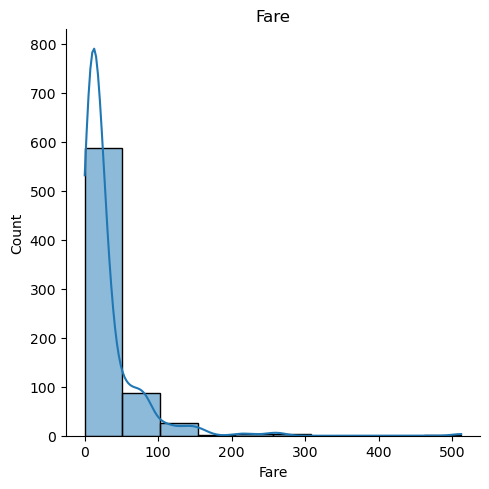

In [308]:
sns.displot(train_data['Fare'], kde=True, rug=False, bins=10)
plt.title('Fare')
plt.tight_layout()
plt.show()


In [309]:
train_data[train_data['Fare'] > 400].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


異常値、外れ値が何らかの想定外が起こった結果（入力ミスとか計測器の故障とか）であれば、

- その行自体を学習データから省く
- 何か別のデータに置き換える

などの処理を行う必要がある。

一方で、外れ値になっていること自体に意味がある場合もある。

例えばここでは、先に「運賃を多く払っているものは優先的に救命ボートに乗っているのではないか」という仮説を検証する必要がある。

### 5. その他ドメイン知識や仮説に基づいたデータの探索

#### 仮説「運賃を多く払っているものは優先的に救命ボートに乗っているのではないか」を検証する

In [310]:
# データをコピーしておく
check = train_data.copy()

# 運賃を10ごとのカテゴリ値に変換した列を作成する(`// 10`は10で割った時の整数値でそれに10を掛けると10ごとのカテゴリになる)
# 例：　167 // 10 * 10 = 16 * 10 = 160
check['FareCat'] = check['Fare'] // 10 * 10
# 列数カウント用ダミー値
check['Count'] = 1

# 運賃カテゴリごとの生存率を求める
fare_survived = check.groupby('FareCat').agg({'Survived': 'mean', 'Count': 'sum'})

fare_survived

,Survived,Count
FareCat,,
0.0,0.205128,273
10.0,0.448980,147
20.0,0.401869,107
30.0,0.469388,49
40.0,0.300000,10
50.0,0.741935,31
60.0,0.333333,15
70.0,0.652174,23
80.0,0.857143,14


Fareが70未満のものは生存率が低いことがわかる。

人数に差があるので一口では言えないが、運賃によって生存率が変わると言えるかもしれない。

高い運賃を払える人は社会的階級が高く、救命ボートに優先的に乗せられた（のかもしれない）。

#### チケットの等級ごとに生存率を確認する

In [311]:
pclass_survived = check.groupby('Pclass').agg({'Survived': 'mean', 'Count': 'sum'})
pclass_survived

,Survived,Count
Pclass,,
1,0.648810,168
2,0.486301,146
3,0.253769,398


明らかにチケットの等級の高いものの生存率が高い。

#### 性別、年齢で生存率が変わるのか確認する

Wikipediaのタイタニックのページには、「[ライトラーは一等船客の「女性と子供を優先する」ことを遵守した](https://ja.wikipedia.org/wiki/%E3%82%BF%E3%82%A4%E3%82%BF%E3%83%8B%E3%83%83%E3%82%AF_(%E5%AE%A2%E8%88%B9)#:~:text=%E3%83%A9%E3%82%A4%E3%83%88%E3%83%A9%E3%83%BC%E3%81%AF%E4%B8%80%E7%AD%89%E8%88%B9%E5%AE%A2%E3%81%AE%E3%80%8C%E5%A5%B3%E6%80%A7%E3%81%A8%E5%AD%90%E4%BE%9B%E3%82%92%E5%84%AA%E5%85%88%E3%81%99%E3%82%8B%E3%80%8D%E3%81%93%E3%81%A8%E3%82%92%E9%81%B5%E5%AE%88%E3%81%97%E3%81%9F)」との記載がある。

データ上その事実が読み取れるのか確認してみる。

In [312]:
# 性別ごとの生存率
sex_survived = check.groupby('Sex').agg({'Survived': 'mean', 'Count': 'sum'})
sex_survived

,Survived,Count
Sex,,
female,0.738462,260
male,0.196903,452


圧倒的に女性の生存率が高い。

In [313]:
# 年齢カテゴリを作成
check['AgeCat'] = check['Age'] // 10 * 10

age_survived = check.groupby('AgeCat').agg({'Survived': 'mean', 'Count': 'sum'})
age_survived

,Survived,Count
AgeCat,,
0.0,0.604167,48
10.0,0.411765,85
20.0,0.340909,176
30.0,0.453846,130
40.0,0.414286,70
50.0,0.421053,38
60.0,0.333333,12
70.0,0.000000,3
80.0,1.000000,1


10歳未満の子供は生存率が高いことがわかる。

In [314]:
# 両方まとめて集計してみる
age_sex_survived = check.groupby(['AgeCat', 'Sex']).agg({'Survived': 'mean', 'Count': 'sum'})
age_sex_survived

Survived  Count
AgeCat Sex                    
0.0    female  0.590909     22
       male    0.615385     26
10.0   female  0.731707     41
       male    0.113636     44
20.0   female  0.711864     59
       male    0.153846    117
30.0   female  0.836735     49
       male    0.222222     81
40.0   female  0.720000     25
       male    0.244444     45
50.0   female  0.866667     15
       male    0.130435     23
60.0   female  1.000000      2
       male    0.200000     10
70.0   male    0.000000      3
80.0   male    1.000000      1

#### 仮説「敬称によって生存率が異なる」

時代的にも敬称は地位を表すことがあるため、`Name`列の敬称に何が使われているかを利用できるかもしれない。


In [315]:
def find_matching_substring(big_string, substrings):
    # check if any substring is present in the big string
    big_string = str(big_string)
    matches = [substring for substring in substrings if substring in big_string]

    # return the first matching substring, or np.nan if none found
    if matches:
        return matches[0]
    else:
        return np.nan

In [316]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

check['Title'] = train_data['Name'].map(lambda x: find_matching_substring(x, title_list))
check.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FareCat,Count,AgeCat,Title
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,0.0,1,10.0,Mrs
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.0,1,2,SC/Paris 2123,41.5792,NaN,C,40.0,1,0.0,Miss
92,93,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.1750,E31,S,60.0,1,40.0,Mr
319,320,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.5000,E34,C,130.0,1,40.0,Mrs
451,452,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,NaN,S,10.0,1,NaN,Mr


In [317]:
# 欠損値のチェック
check['Title'].isnull().sum()

0

In [318]:
# 敬称ごとの生存率を集計する
title_survived = check.groupby('Title').agg({'Survived': 'mean', "Count": 'sum'})
title_survived

,Survived,Count
Title,,
Col,0.500000,2
Countess,1.000000,1
Dr,0.428571,7
Jonkheer,0.000000,1
Major,0.500000,2
Master,0.593750,32
Miss,0.691275,149
Mme,1.000000,1
Mr,0.163772,403


男性につける敬称のうち、`Dr`, `Master`, `Mr`を比べると、

`Master` > `Dr` > `Mr` の順に生存率が高いことがわかる。

## Tips: 率を平均(mean)で求める理由

先ほどから、生存率を求める計算方法に'mean'(平均)を指定している。

これは生存したか否かの列`Survived`が0, 1の2値であることを利用している。

生存率を求める方法は、

$$
    生存率 = \frac{Survived=1の数}{全体の人数}
$$

となる。

一方で、`Survived`が0, 1の2値であるときのSurvivedの平均は

$$
    Survivedの平均 = \frac{全行のSurvived(0,1)の合計}{行数}
$$

であり、データの一行一行が一人一人の人なので、`行数`は`全体の人数`と同値だし、<br>
0 or 1 をとるデータの合計は1の数を数えているのと同じである。

よって、

$$
    Survivedの平均 = \frac{全行のSurvived(0,1)の合計}{行数} = \frac{Survived=1の数}{全体の人数} = 生存率
$$

と言える。

## 前処理 ~ データクレンジングとフィーチャーエンジニアリング ~

今度は実際に、データを使って機械学習モデルを学習させるための前準備として、データの処理を行っていきます。

#### テストデータと訓練データを結合する。

まず、テストデータ(test_data)と訓練データ(train_data)を結合します。
また、後で分割が容易になるように元々テストデータなのかどうかのフラグ列も追加します(`isTest` 0: テストデータではない、1: テストデータである)

せっかく最初の時点で、分割したものをなぜまた結合するのかと思うだろうが、<br>
こうすることで、例えば欠損値を埋める処理を`train_data`と`test_data`の2回行う必要がなくなるなど、<br>
前処理を都合よく行うことができる。

In [319]:
col_name = 'isTest'

# 以下のようにすることで、全行に1(または0)を入れることができる。
test_data[col_name] = 1
train_data[col_name] = 0

In [320]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isTest
154,155,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S,1
475,476,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S,1
518,519,2,"Angle, Mrs. William A (Florence ""Mary"" Agnes H...",female,36.0,1,0,226875,26.0000,NaN,S,1
599,600,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,1
646,647,3,"Cor, Mr. Liudevit",male,19.0,0,0,349231,7.8958,NaN,S,1


In [321]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isTest
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,0
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.0,1,2,SC/Paris 2123,41.5792,NaN,C,0
92,93,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.1750,E31,S,0
319,320,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.5000,E34,C,0
451,452,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,NaN,S,0


isTestに意図通りの値が入っている。

In [322]:
# train_dataとtest_dataを結合する

dat = pd.concat([train_data, test_data])

In [323]:
# 行数を確認して結合ができているか確認する(shapeは(行数, 列数)なので、shape[0]は行数を取得できる)
print("train_data + test_data", train_data.shape[0] + test_data.shape[0])
print("dat", dat.shape[0])


train_data + test_data 891
dat 891


#### 欠損値の処理

`Age`, `Cabin`, `Embarked`に欠損値があるため、何らかの処理をする必要があります。

欠損値の処理方法は、利用するモデルやデータの性質などによる。

ここでは、`Age`は中央値、`Embarked`は最頻値で欠損値を埋めることにする。

簡単にするため、`Cabin`は推論に用いないことにし、欠損値はそのままにしておくことにする。

In [324]:
mean_age = dat['Age'].mean()
top_embarked = dat[['Embarked']].describe(exclude='number').at['top', 'Embarked']

print(mean_age)
print(top_embarked)

29.69911764705882
S


In [325]:
# それぞれ欠損値を埋める(fillnaを用いる)
dat['Age'].fillna(mean_age, inplace=True)
dat['Embarked'].fillna(top_embarked, inplace=True)

# 確認する
dat[['Age', 'Embarked']].isna().sum()

Age         0
Embarked    0
dtype: int64

#### 異常値の処理

異常値もここで処理をすることになる。

`Fare`に外れ値が含まれることがわかっているが、等級が生存率に影響を与えていることがわかっているため、

今回は特に処理を行わないことにする。


#### 敬称を特徴量に加える

先ほど、敬称ごとに生存率に差が出る可能性があるとわかったため、それを特徴量に含める

In [326]:
dat['Title'] = dat['Name'].map(lambda x: find_matching_substring(x, title_list))
dat[['Title']].isnull().sum()

Title    0
dtype: int64

#### カテゴリ値の変換

多くの機械学習モデルで、文字列データより数値データが好ましい場合がある。（文字列で問題ないモデルもあるが）

また、カテゴリ値をダミー変数とする方が良い場合、しなくても良い場合などさまざまではある。

そのあたりは、モデルやデータの性質によるのだが、

ここでは`pandas.get_dummies`を用いてダミー変数に変換してみる。

ダミー変数とは？<br>
https://bellcurve.jp/statistics/glossary/1538.html

In [327]:
dat = pd.get_dummies(dat, drop_first=True, columns=['Sex', 'Embarked', 'Title'])

In [328]:
# 最終的な列

dat.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'isTest', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Title_Col', 'Title_Countess', 'Title_Don', 'Title_Dr',
       'Title_Jonkheer', 'Title_Major', 'Title_Master', 'Title_Miss',
       'Title_Mlle', 'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms',
       'Title_Rev'],
      dtype='object')

In [329]:
dat.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title_Jonkheer,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev
855,856,1.0,3,"Aks, Mrs. Sam (Leah Rosen)",18.000000,0,1,392091,9.3500,NaN,...,0,0,0,0,0,0,0,1,0,0
43,44,1.0,2,"Laroche, Miss. Simonne Marie Anne Andree",3.000000,1,2,SC/Paris 2123,41.5792,NaN,...,0,0,0,1,0,0,0,0,0,0
92,93,0.0,1,"Chaffee, Mr. Herbert Fuller",46.000000,1,0,W.E.P. 5734,61.1750,E31,...,0,0,0,0,0,0,1,0,0,0
319,320,1.0,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",40.000000,1,1,16966,134.5000,E34,...,0,0,0,0,0,0,0,1,0,0
451,452,0.0,3,"Hagland, Mr. Ingvald Olai Olsen",29.699118,1,0,65303,19.9667,NaN,...,0,0,0,0,0,0,1,0,0,0


## モデルの作成、学習、推論の実行

欠損値や外れ値の処理をし、新しい特徴量を作成したので、
早速モデルを作成し、学習・推論して結果を見てみる。

In [330]:
# 前処理をしたデータを、 学習データ、学習データの教師データ、検証データに分ける。

train = dat[dat['isTest'] == 0].copy()
test = dat[dat['isTest'] ==1 ].copy()

columns = ['Pclass', 'Age', 'SibSp', 'Parch',
       'Fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Title_Col', 'Title_Countess', 'Title_Don', 'Title_Dr',
       'Title_Jonkheer', 'Title_Major', 'Title_Master', 'Title_Miss',
       'Title_Mlle', 'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms',
       'Title_Rev']

X_train = train[columns]
y_train = train['Survived']
X_test = test[columns]

In [331]:
# Random Forests を利用する

from sklearn.ensemble import RandomForestClassifier

# ハイパーパラメータは一旦適当な値にしている
rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=79)

# 学習を行う
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_jobs=-1, random_state=79)

これで学習が完了！

このモデルを使って推論をしてみる。

In [332]:
y_pred_rf = rnd_clf.predict(X_test)

正解率を求めると、

In [333]:
from sklearn.metrics import accuracy_score

accuracy_score(test_survived['Survived'], y_pred_rf)

0.8491620111731844